In [1]:
# Let's import the needed packages for further use ! 
import sys,os

import numpy as np
import copy
import matplotlib.pyplot as plt
plt.ioff()
# %matplotlib notebook

# Jax libraries : 
import jax
import jax.numpy as jnp
from jax import vmap
from jax.tree_util import tree_map
from jax.scipy.special import gammaln,digamma,betaln
from tensorflow_probability.substrates import jax as tfp
from functools import partial

# Our own package to simulate and invert Active Inference models 
import actynf
import actynf.jaxtynf

from actynf.jaxtynf.jax_toolbox import _normalize


# A few helper functions ...
from tools import clever_running_mean
from tools import save_output,extract_training_data
from tools import to_list_of_one_hots
from tools import imshow_with_labels,plot_trials,plot_trials_and_data,plot_trials_new

# Loading the experimental measures !
from load_data import get_all_derivatives_in_order,preprocess_data


# A FEW CONSTANTS : 
XP1_DATA_PATH = os.path.join("data_downloaded","xp1")

subj_names,eeg_data,bold_data,trial_time_stamps = get_all_derivatives_in_order(XP1_DATA_PATH)

In [2]:
# Preprocessing :

options = {
    "n_actions_per_run" : 10, # 2, 5 or 10 (a denominator of 10 !),
    "n_outcomes":{
        "i_eeg" : 10,
        "o_eeg" : 10,
        "i_bold" : 8,
        "o_bold" : 8
    }
}

# Loading the experimental values we're trying to match
data_dictionnary = preprocess_data(eeg_data,bold_data,trial_time_stamps,options)
print(data_dictionnary["bold"])

{'intensity': {'val': array([[[[[0.1       , 0.1       , 0.25      , ..., 0.1       ,
           0.1       , 0.        ],
          [0.1       , 0.        , 0.        , ..., 0.        ,
           0.        , 1.        ],
          [0.1       , 0.        , 0.        , ..., 0.1       ,
           0.        , 1.        ],
          ...,
          [0.        , 0.1       , 0.1       , ..., 0.        ,
           0.1       , 0.1       ],
          [0.1       , 0.1       , 0.        , ..., 0.5       ,
           0.        , 0.1       ],
          [0.1       , 0.1       , 0.25      , ..., 0.        ,
           0.1       , 0.        ]],

         [[0.1       , 0.        , 0.        , ..., 0.1       ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.1       , 0.        ],
          [0.        , 0.1       , 0.        , ..., 0.1       ,
           0.        , 0.1       ],
          ...,
          [0.1       , 0.        , 0.        ,

[10, 10, 8, 8]


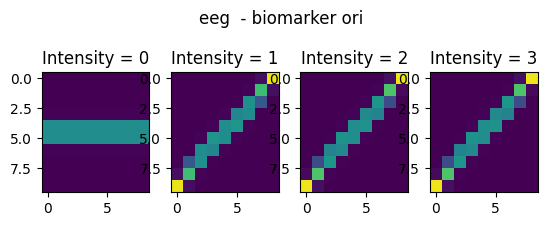

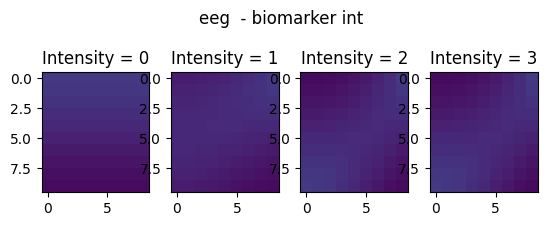

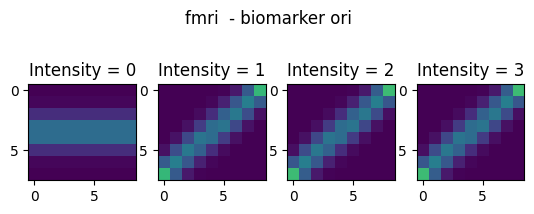

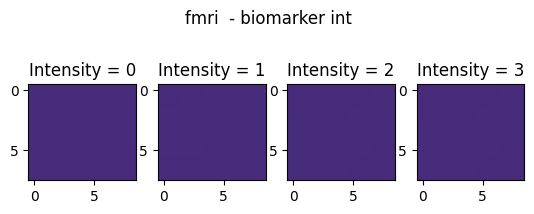

In [3]:
# We use the following set of models : 

Ns = [3,9]  # Intensity x Orientation of the mental imagery of the subject

# Number of discrete outcomes for each observed modality and each sensor type :
# We have 4 observation modalities ! EEG_int, EEG_lat, BOLD_int and BOLD_lat !
# Our inversion pipeline allows us to take them all into account, incorporating
# priors we have regarding their noise and how much confidence we have in this assumption.
Nos = [data_dictionnary["eeg"]["intensity"]["val"].shape[-1],data_dictionnary["eeg"]["laterality"]["val"].shape[-1],
       data_dictionnary["bold"]["intensity"]["val"].shape[-1],data_dictionnary["bold"]["laterality"]["val"].shape[-1]]

print(Nos)


# No_bold = [5,5]           
# No_eeg = [5,5]

# Emission model : the two hidden states are the orientation and the intensity of the subjects right ERD. 

def ERDs(normed_orientation,normed_intensity,rest_cst=1.0):
        """ 
        We assume that the ERDs in the left vs right sensorimotor area are drivent by two cognitive components:
        - Intensity 
        - Orientation
        """
        PI = 3.1415
        l_erd = normed_intensity*jnp.cos(normed_orientation*PI/2.0) + rest_cst  # between krest and krest + 1.0
        r_erd = normed_intensity*jnp.sin(normed_orientation*PI/2.0) + rest_cst
        return r_erd,l_erd

def get_aai(normed_orientation,normed_intensity,krest):
        """
        A cognitive to feedback model function, based only on the laterality of the right hand motor brain activity.
        2 mental states :
        - Intensity
        - Orientation -- normed_orientation is a measure of angle between 0 and 90°   
        We have : 
        rh_mi = int * cos(ori)
        lh_mi = int * sin(ori)  
        """
        r_erd,l_erd = ERDs(normed_orientation,normed_intensity,krest)
        aai =  (l_erd - r_erd)/(l_erd + r_erd)  # Minus
        return aai  # Normalized to -1 -> 1
        # return (aai+1)/2.0  # Normalized to 0 -> 1


from process import discretize_normal_pdf

def laterality_feedback(_int,_ori,_std,_n_feedback_bins,_base_value=0.01):
    
    # The laterality feedback is a noisy estimator based on the ERD assymetry : 
    _feedback_mean = get_aai(_ori,_int,_base_value)
    
    discretized_feedback,_ = discretize_normal_pdf(_feedback_mean,_std,_n_feedback_bins,-1.0,1.0)

    return discretized_feedback


def intensity_feedback(_int,_ori,_std,_n_feedback_bins,_base_value=0.01):
    # The intensity feedback is a noisy estimator based on the Left ERD intensity : 
    r_erd,l_erd = ERDs(_ori,_int,_base_value)
    
    _feedback_mean = l_erd - _base_value
    
    discretized_feedback,_ = discretize_normal_pdf(_feedback_mean,_std,_n_feedback_bins,0.0,1.0)

    return discretized_feedback
    
    
# We have no real prior about the starting state in the series :
pD = [jnp.ones((ns,)) for ns in Ns]


states_intensity = jnp.linspace(0,1.0,Ns[0])
states_orientation = jnp.linspace(0,1.0,Ns[1])

pA = []
sensor_noise = [0.1,0.5,0.25,5.0] # Our priors about the noise for each observation modality
sensor_prior_confidence = [10.0,10.0,10.0,10.0] # Noise parameters for each observation modality
type = ["ori","int","ori","int"]
sensor = ["eeg","eeg","fmri","fmri"]

for modality,(n_out_m,prior_noise_m,prior_weight_m) in enumerate(zip(Nos,sensor_noise,sensor_prior_confidence)):
    
    
    if type[modality]=="ori":
        emission_builder = lambda x,y: laterality_feedback(x,y,prior_noise_m,n_out_m)
    else :
        emission_builder = lambda x,y: intensity_feedback(x,y,prior_noise_m,n_out_m)
        
    feedback_matrix = vmap(vmap(emission_builder,in_axes=(None,0)),in_axes=(0,None))(states_intensity,states_orientation)

    
    feedback_matrix = jnp.moveaxis(feedback_matrix,-1,0)
    pA.append(feedback_matrix*prior_weight_m)
    
    # # Plot the matrices if needed :
    # print(feedback_matrix.shape)
    fig,axs = plt.subplots(1,4)
    fig.suptitle(sensor[modality] + "  - biomarker " +type[modality],y=0.75)
    for i,ax in enumerate(axs) : 
        ax.set_title("Intensity = {}".format(i))
        ax.imshow(np.array(_normalize(pA[-1][:,i,:])[0]),vmin=0.0,vmax=1.0)
    # # fig.show()
    plt.show()
    
# Laterality feedbacks are based on the orientation of the ERD
# print(pA)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1.]]


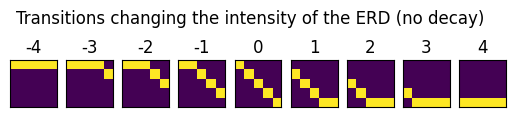

(5, 5, 5)
(5, 5, 5)


TypeError: bad operand type for unary -: 'list'

In [32]:

# Finally, transitions ! 
# There are 2 hidden factors for which we need to define precise transition priors :
# These depend on our goals for this set of simulations. Here, let's try to find the most likely 
# existing mental transitions assuming a flat transition prior. 
# Importantly : 
# - We can not really make the diffference between two similar transitions. Two transitions doing
#     the same thing is probably useless


# Intensity : let's assume that some actions allow us to increase the intensity of the ERD,

Ns = 5
up_action = jnp.arange(Ns)


stay_the_same_transition = jax.nn.one_hot(up_action,Ns)
up_k_level_vector = lambda k : jnp.swapaxes(jax.nn.one_hot(jnp.clip(jnp.arange(Ns) + k,0,Ns-1),Ns),0,1)
print(up_k_level_vector(2))

ks = range(-Ns+1,Ns)
fig,axes = plt.subplots(1,len(ks))
fig.suptitle("Transitions changing the intensity of the ERD (no decay)",y=0.65)
for i,k in enumerate(ks):
    ax = axes[i]
    ax.set_title("{}".format(k) )
    ax.imshow(up_k_level_vector(k))
    # for major ticks
    ax.set_xticks([])
    # for minor ticks
    ax.set_xticks([], minor=True)
    # for major ticks
    ax.set_yticks([])
    # for minor ticks
    ax.set_yticks([], minor=True)
plt.show()


def build_basic_transition_matrix(action,p_effect,Ns):
    # How to get a decay ? Use the transitions from one state to a rest position :
    starting_states = jnp.arange(Ns)

    # Depending on the action u performed, if there is no decay, 
    # the state will be s+u :
    states_after_action = jnp.clip(starting_states + action,0,Ns-1)
    action_effect = jnp.swapaxes(jax.nn.one_hot(states_after_action,Ns),0,1)

    return action_effect*p_effect + jnp.eye(Ns)*(1-p_effect)


def build_drift_matrix(p_lows,Ns,rest_state):
    # p_lows is a fixed shape array of transition probabilities
    
    # The drift matrix is a set of transitions towards the drift state added together & normalized
    starting_states = jnp.arange(Ns)
    
    abs_potential_transitions = jnp.arange(Ns)
    direction_of_decay_func = jnp.clip(rest_state-starting_states,-1,1)
    
    # All lvl transitions due to drift: (here, it is possible to "drift beyond" the resting state)
    # We may implement an additionnal clipping part somewhere if this is not wanted
    possible_drift_size = p_lows.shape[0]
    levels = jnp.arange(1,possible_drift_size+1)
    
    states_after_lvl_drifts = vmap(lambda lvl : lvl*direction_of_decay_func + starting_states)(levels)
    states_after_lvl_drifts = jnp.clip(states_after_lvl_drifts,0,Ns-1)
    
    vec_states_after_lvl_drifts = jnp.swapaxes(jax.nn.one_hot(states_after_lvl_drifts,Ns),0,-1)
    
    return jnp.einsum("iju,u->ij",vec_states_after_lvl_drifts,p_lows)

def build_full_transition_mapping_with_drift(actions,p_effect,p_lows,Ns,rest_state) :
    # If the subject is idle in a cognitive dimension, there is a 
    # drift towards resting states : The direction of this "decay" depends on 
    # the initial state : 
    
    # Get the transition matrix for all actions : 
    all_transitions = vmap(build_basic_transition_matrix,in_axes=(0,None,None),out_axes=-1)(actions,p_effect,Ns)
    
    # Get the drift matrix for idle actions :
    drift_mat = build_drift_matrix(p_lows,Ns,rest_state)

    
    # Get some mask that will tell us this action is a neutral action :
    filter_idle = jnp.clip(1.0 - jnp.abs(actions),0)
    
    # If this is an idle action, the drift occurs and 
    # the density of the "intended" transition is reduced : 
    density_drift = jnp.sum(p_lows)*filter_idle
    density_intended = 1.0 - density_drift
    
    intended_part = jnp.einsum("iju,u->iju",all_transitions,density_intended) 
    drift_part = jnp.einsum("ij,u->iju",drift_mat,filter_idle)
    return intended_part + drift_part
    
    
# action_ranges = [jnp.array([-2,-1,0,1,2]),jnp.array([-2,-1,0,1,2])]
action_ranges = [jnp.array([-2,-1,0,1,2]),jnp.array([-2,-1,0,1,2])]
# action_ranges = [jnp.array([-1,0,1]),jnp.array([-1,0,1])]
p_drift = [jnp.array([0.5,0.2]),jnp.array([0.5,0.2])]
p_effect = [1.00,1.00]
Ns = [5,5]
resting_states = [0,2]
for act,pd,pe,ns,rs in zip(action_ranges,p_drift,p_effect,Ns,resting_states):
    M = build_full_transition_mapping_with_drift(act,pe,pd,ns,rs)
    print(M.shape)

# ks = range(-Ns+1,Ns)
# fig,axes = plt.subplots(1,len(ks))
# fig.suptitle("Transitions changing the intensity of the ERD (fixed decay)",y=0.65)
# for i,k in enumerate(ks):
#     ax = axes[i]
#     ax.set_title("{}".format(k) )
#     ax.imshow(M[...,i],vmin=0,vmax=1)
#     # for major ticks
#     ax.set_xticks([])
#     # for minor ticks
#     ax.set_xticks([], minor=True)
#     # for major ticks
#     ax.set_yticks([])
#     # for minor ticks
#     ax.set_yticks([], minor=True)
# plt.show()


# ks = range(-Ns+1,Ns)
# fig,axes = plt.subplots(1,len(ks))
# fig.suptitle("Transitions changing the orientation of the ERD (fixed decay)",y=0.65)
# for i,k in enumerate(ks):
#     ax = axes[i]
#     ax.set_title("{}".format(k) )
#     ax.imshow(build_matrix_with_decay(k,0.3,Ns,2))
#     # for major ticks
#     ax.set_xticks([])
#     # for minor ticks
#     ax.set_xticks([], minor=True)
#     # for major ticks
#     ax.set_yticks([])
#     # for minor ticks
#     ax.set_yticks([], minor=True)
# plt.show()